# Replaying Old Data

- Work under a separate branch with git (i.e. git checkout -b my-new-branch)

- Make a new folder in Projects (for your specific purposes)

- Copy this ipynb file that folder

- The data is stored on L-Drive

- the main gist of re-playing existing data is:
    - that your first load everything into a big matrix with mne
    - then initialize a specific **amp** (i.e., the "replayamp")
    - then do exactly the same as normal, with a while True loop with calls to amp.get_data()
    

In [1]:
import logging
logging.basicConfig(level=logging.WARNING)

In [2]:
# import all the needed stuff:

import time
import matplotlib
import sys
import scipy
import numpy as np
import easygui
import matplotlib.pyplot as plt
import mne
from IPython.display import clear_output
import re
import pickle
import dynarray

sys.path.append("../../mushu")  # driver for the amps
sys.path.append("../../mushu/libmushu")
import libmushu

sys.path.append("../../nftools")  # handy stuff needed for NF
from nftools.loopcontrol import LoopState
from nftools.analysis import convert_alld_allm_to_mne
from nftools.analysis import select_part_from_mne_dataset
from nftools.analysis import plot_compare_two_spectra

sys.path.append("../../wyrm")  # real-time data analysis
from wyrm.types import RingBuffer
from wyrm.types import BlockBuffer
from wyrm import io

In [3]:
# this is the replay notebook - so select a file for playback - this is for brainvision files.

fn=easygui.fileopenbox(default='/media/ldrive/Lab_MichaelB/Johan/nf/rawdata/*.vhdr')
print(fn)

raw_fromfile = mne.io.read_raw_brainvision(fn)
montage=mne.channels.read_montage('standard_1005', ch_names=raw_fromfile.ch_names)  # always use MNE definitions
raw_fromfile.set_montage(montage)

/media/ldrive/Lab_MichaelB/Johan/nf/rawdata/CH003/eeg/Chall_Week 3_2018-10-03_16-27-18.vhdr
Extracting parameters from /media/ldrive/Lab_MichaelB/Johan/nf/rawdata/CH003/eeg/Chall_Week 3_2018-10-03_16-27-18.vhdr...
Setting channel info structure...
Currently, 1 trigger(s) will be dropped, such as [Impedance]. Consider using ``event_id`` to parse triggers that do not follow the 'S###' pattern.
The following EEG sensors did not have a position specified in the selected montage: ['EOG']. Their position has been left untouched.


<ipython-input-3-b397cd66af22>:6: RuntimeWarning: Currently, 1 trigger(s) will be dropped, such as [Impedance]. Consider using ``event_id`` to parse triggers that do not follow the 'S###' pattern.
  raw_fromfile = mne.io.read_raw_brainvision(fn)
<ipython-input-3-b397cd66af22>:8: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['EOG']. Their position has been left untouched.
  raw_fromfile.set_montage(montage)


<RawBrainVision  |  Chall_Week 3_2018-10-03_16-27-18.eeg, n_channels x n_times : 65 x 846437 (423.2 sec), ~164 kB, data not loaded>

In [2]:
# this is the replay notebook - so select a file for playback - this is for eeglab files.

fn=easygui.fileopenbox(default='*.set')
print(fn)

raw_fromfile = mne.io.read_raw_eeglab(fn)
montage=mne.channels.read_montage('standard_1005', ch_names=raw_fromfile.ch_names)  # always use MNE definitions
raw_fromfile.set_montage(montage)

None


TypeError: expected str, bytes or os.PathLike object, not NoneType

In [4]:
# prepare data for replay (warning: need probably a lot of memory)

mul_factor = 1.0
if 1e-6 in [raw_fromfile.info['chs'][0]['cal'], raw_fromfile.info['chs'][0]['range']]:
    mul_factor = 1.0 / 1e-6

seed_d=raw_fromfile[:-1,:][0] * mul_factor  # scale the data to seed (so no 1e-6 stuff in the replayed data)
seed_d=np.array(seed_d.transpose())
seed_ch=raw_fromfile.ch_names[0:-1]
seed_fs=raw_fromfile.info['sfreq']

# prepare for replay; markers:
seed_mdata=np.transpose(raw_fromfile[-1,:][0])
seed_m=[[i / raw_fromfile.info['sfreq'] * 1000, int(m[0])] for i, m in enumerate(seed_mdata) if m > 0] 

In [6]:
amp = libmushu.get_amp('replayamp')
amp.configure(seed_d, seed_m, seed_ch, seed_fs, realtime=True, blocksize_samples=100)

In [16]:
alld=dynarray.DynamicArray((None, len(amp.get_channels())))     # data
allm=[]     # markers
sfreq = amp.get_sampling_frequency()  # sampling frequency
ch_names=amp.get_channels()  # channel names

markTime=time.time()
updateTime = 0.1  # run some kind of calculation every X seconds
buffSize = 1.0  # run calculation on last X seconds of data


rb = RingBuffer(buffSize * 1000)  # the buffer containing the last X seconds of data - declared in MILISECONDS
totalTime = seed_d.shape[0]/raw_fromfile.info['sfreq']

In [17]:
amp.start()

DEBUG:libmushu.ampdecorator:Waiting for marker server to become ready...
DEBUG:asyncio:Using selector: EpollSelector
DEBUG:libmushu.ampdecorator:Marker server is ready.


In [18]:
# l=LoopState(); l.start()
markeroffset = 0  # needed to store all data in one big mat/vector
t0=time.time()
curTime=time.time()
st=''
while curTime - t0 < totalTime:  # l.get_state() != 'Stop':
   
    
    # keep track of time:
    curTime = time.time()

    
    # this is where you get the data
    data, marker = amp.get_data()
    cnt = io.convert_mushu_data(data, marker, sfreq, ch_names)
    newsamples = cnt.data.shape[0]

    
    rb.append(cnt)
    
    
    
    # do the following every 0.1 msec:
    if curTime - markTime > updateTime:
        # do Stuff
        
        markTime = curTime
        # 1) obtain last 1-second(s)
        d = rb.get()
        
        # thomas does stuff here
        
        
        # we send the value to BCI/STIM
        
        
        
        clear_output(wait=True)  # write some logging information here
        print('Playing Back - time = %f' % (curTime - t0))
        print('Length Markers: %d' % len(allm))
        print(data.shape)

        

        
    
    # append it to the big matrix
    alld.extend(data)
    for m in marker:
        allm.append([m[0] + markeroffset, m[1]])
    markeroffset += newsamples / float(sfreq) * 1000.

Playing Back - time = 690.410807
Length Markers: 2555
(0, 64)


In [19]:
amp.stop()
alld.shrink_to_fit()

DEBUG:libmushu.ampdecorator:Waiting for marker server process to stop...
DEBUG:libmushu.ampdecorator:Marker server process stopped.


amplifier stopped!


In [50]:
# write to disk, so we can re-load it later:

t={'alld':alld, 'allm':allm, 'ch_names':ch_names, 'sfreq':sfreq}
with open('c-allm-and-alld.pkl', 'wb') as f:
    pickle.dump(t, f)

In [40]:
# load from disk:

with open('c-allm-and-alld.pkl','rb') as f:
    t=pickle.load(f)
for key in t.keys():
    locals()[key] = t[key]

In [51]:
alld.shape

(3452500, 64)

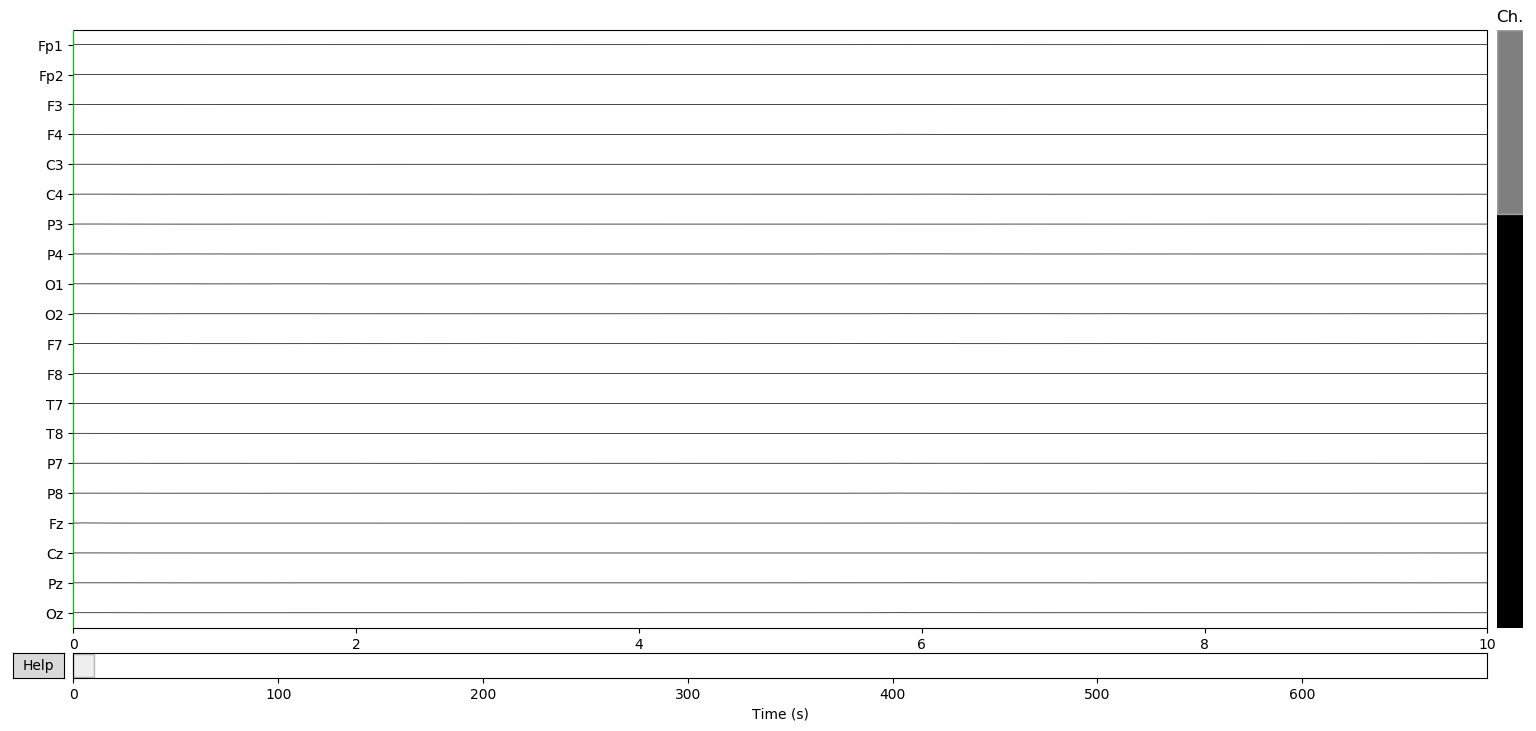

In [37]:
raw.plot(scalings='auto')

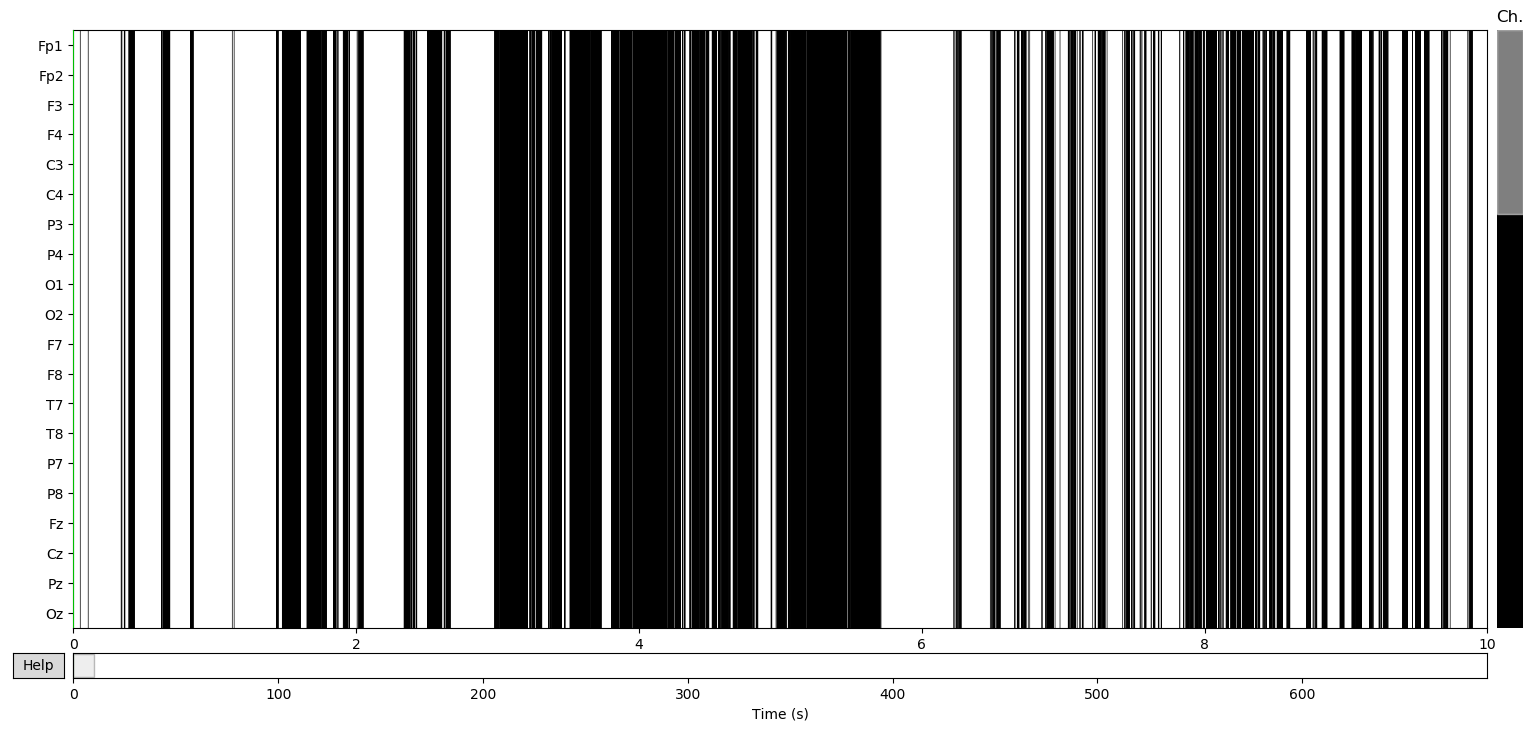

In [35]:
raw.plot()

In [52]:
raw = convert_alld_allm_to_mne(alld, allm, ch_names, sfreq)  # covert to MNE
raw.set_eeg_reference(ref_channels='average')

The following EEG sensors did not have a position specified in the selected montage: ['ECG']. Their position has been left untouched.


../../nftools/nftools/analysis.py:30: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['ECG']. Their position has been left untouched.
  montage=montage


Creating RawArray with float64 data, n_channels=64, n_times=3452500
    Range : 0 ... 3452499 =      0.000 ...   690.500 secs
Ready.
5000.0
Creating RawArray with float64 data, n_channels=1, n_times=3452500
    Range : 0 ... 3452499 =      0.000 ...   690.500 secs
Ready.
Applying average reference.
Applying a custom EEG reference.


<RawArray  |  None, n_channels x n_times : 65 x 3452500 (690.5 sec), ~1.67 GB, data loaded>

In [38]:
picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False,
                       stim=False, exclude='bads')
raw.resample(1000)
raw.notch_filter(np.arange(50, 300, 50), picks=picks, filter_length='auto', phase='zero')
# add it (potentialy) some other preprocessing steps here

2555 events found
Event IDs: [  1   2   3   4   5   6   7   8  11  12  13  14  15  21  23  26  30  31
  40  41  42  43  44  45  46  51  52  53  54  55  56  60  80  81  82  83
  84  85  86 131 132 133 134 135 136 140 201 202 203 204 221 222 223 224
 225 226 227 228 229 231 232 233 234 241 242 243 244 245 246 247]
2555 events found
Event IDs: [  1   2   3   4   5   6   7   8  11  12  13  14  15  21  23  26  30  31
  40  41  42  43  44  45  46  51  52  53  54  55  56  60  80  81  82  83
  84  85  86 131 132 133 134 135 136 140 201 202 203 204 221 222 223 224
 225 226 227 228 229 231 232 233 234 241 242 243 244 245 246 247]
Setting up band-stop filter
Filter length of 6601 samples (6.601 sec) selected


<RawArray  |  None, n_channels x n_times : 65 x 690500 (690.5 sec), ~342.6 MB, data loaded>

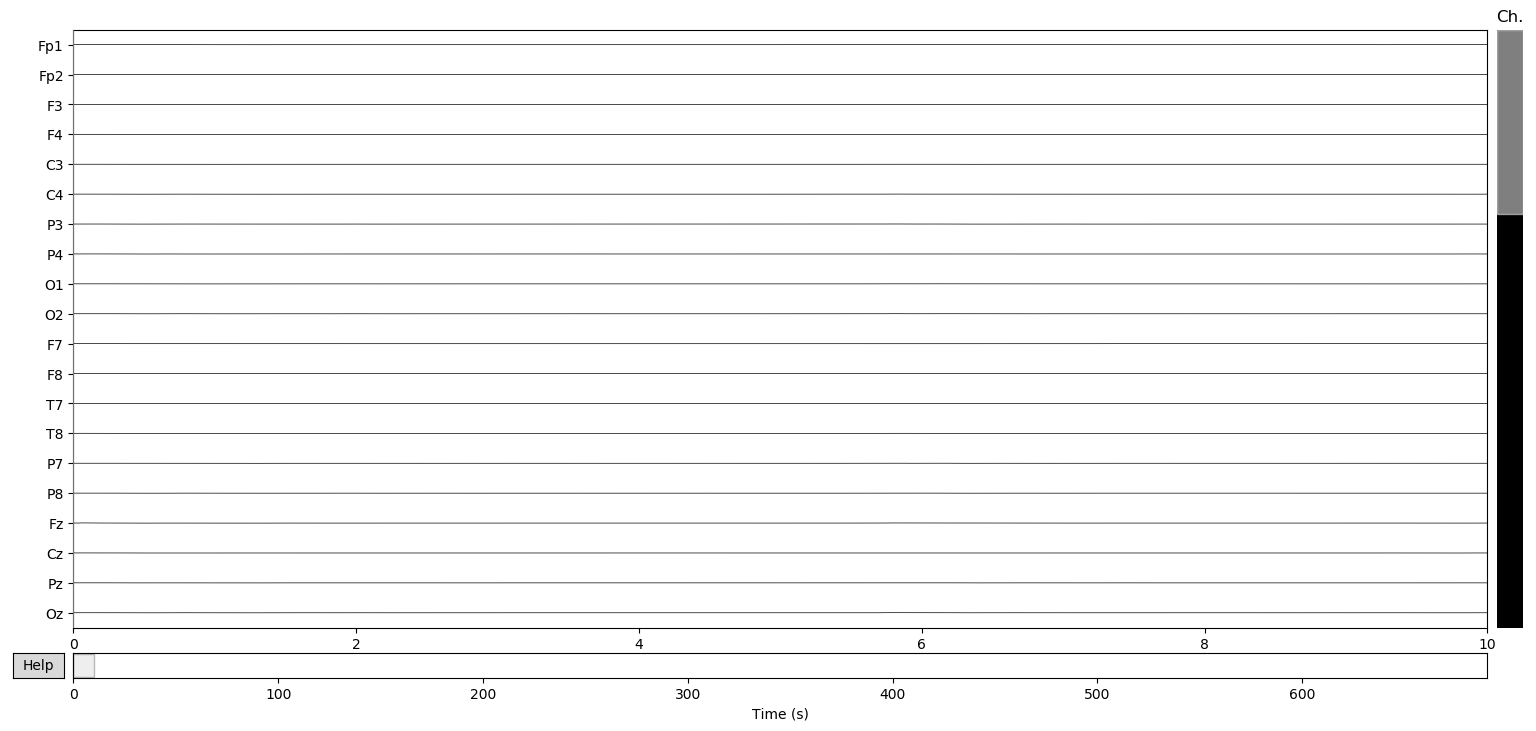

In [39]:
raw.plot(scalings='auto')

In [53]:
# split data sets between EO and EC

newraw_eo=select_part_from_mne_dataset(raw, markers=[201, 202])
newraw_ec=select_part_from_mne_dataset(raw, markers=[203, 204])

using markers
2555 events found
Event IDs: [  1   2   3   4   5   6   7   8  11  12  13  14  15  21  23  26  30  31
  40  41  42  43  44  45  46  51  52  53  54  55  56  60  80  81  82  83
  84  85  86 131 132 133 134 135 136 140 201 202 203 204 221 222 223 224
 225 226 227 228 229 231 232 233 234 241 242 243 244 245 246 247]
using boundaries
[[ 2249.8828125  2249.03125    2247.9921875 ...  2230.203125
   2231.28125    2233.6015625]
 [-1886.6171875 -1887.96875   -1889.0078125 ... -8620.296875
  -8618.21875   -8616.8984375]
 [ 1183.3828125  1181.53125    1180.4921875 ...  1146.703125
   1147.78125    1150.1015625]
 ...
 [ -315.6171875  -316.96875    -318.5078125 ... -1994.796875
  -1994.21875   -1992.3984375]
 [  206.3828125   205.53125     203.4921875 ... -1987.296875
  -1986.21875   -1985.8984375]
 [  201.            0.            0.        ...     0.
      0.            0.       ]]
Creating RawArray with float64 data, n_channels=65, n_times=250048
    Range : 0 ... 250047 =      0.00

In [54]:
%matplotlib qt5

DEBUG:matplotlib.backends:backend Qt5Agg version 5.9.2


In [56]:
d1=plot_compare_two_spectra(newraw_eo, newraw_ec, freqs=[1, 25], n_fft=2048, n_overlap=512, chs_to_include=['Oz','O1','O2','PO8', 'PO7'], freq_lims_topoplot=[7, 12], pow_lims = [-10, 25])


Effective window size : 3.277 (s)
Effective window size : 3.277 (s)
['Oz', 'O1', 'O2', 'PO8', 'PO7']
[8, 9, 19, 57, 58]


In [ ]:
newraw_eo.plot(scalings='auto')

In [ ]:
mne.viz.plot_sensors(newraw_ec.info, show_names=True)

In [ ]:
newraw_ec.plot_psd(tmax=np.inf, fmax=250, n_fft=2048)

In [ ]:
# some attempts at doing ICA
from mne.preprocessing import ICA
method = 'fastica'
n_components = 25
decim = 3
random_state = 23
ica = ICA(n_components=n_components, method=method, random_state=random_state)
print(ica)

picks_eeg = mne.pick_types(newraw_ec.info, meg=False, eeg=True, eog=False,
                           stim=False, exclude='bads')
reject = dict(eeg=1e-3)
ica.fit(newraw_ec, picks=picks_eeg, decim=decim, reject=reject)
print(ica)